# Assignment 33

#  In this assignment we have to make ARIMA model over shampoo sales data and check the MSE between predicted and actual value. 

Data can download data in .csv format from the following link: https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line 
        

In [29]:
# Loading libraries

import pandas as pd
from pandas import read_csv
from pandas import tseries
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime


#### Loading data

In [72]:
def parser(x):
    return datetime.strptime('190'+x, '%Y/%m')


series = read_csv('sales-of-shampoo1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [73]:
series.head()

1/1
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
Name: 266, dtype: float64

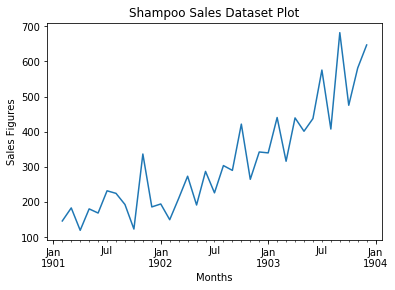

In [63]:
# plot

series.plot()

pyplot.title('Shampoo Sales Dataset Plot')
pyplot.xlabel('Months')
pyplot.ylabel('Sales Figures')
pyplot.show()

The data is plotted as a time series with the month along the x-axis and sales figures on the y-axis.

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. Below is the plot of the autocorrelation for a large number of lags in the time series.


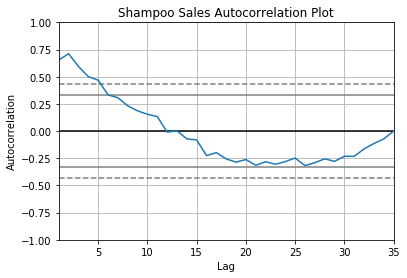

In [64]:
from pandas.plotting import autocorrelation_plot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y/%m')
 
series = read_csv('sales-of-shampoo1.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
autocorrelation_plot(series)
pyplot.title('Shampoo Sales Autocorrelation Plot')
pyplot.show()

We can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

### Fitting the model

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [65]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

                             ARIMA Model Results                              
Dep. Variable:                  D.266   No. Observations:                   34
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -188.279
Method:                       css-mle   S.D. of innovations             59.834
Date:                Tue, 30 Oct 2018   AIC                            390.559
Time:                        12:30:27   BIC                            401.243
Sample:                    03-01-1901   HQIC                           394.203
                         - 12-01-1903                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.5140      3.340      4.046      0.000       6.968      20.060
ar.L1.D.266    -1.1471      0.171     -6.709      0.000      -1.482      -0.812
ar.L2.D.266    -0.6961      0.265     -2.626    

ARIMA model Results summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

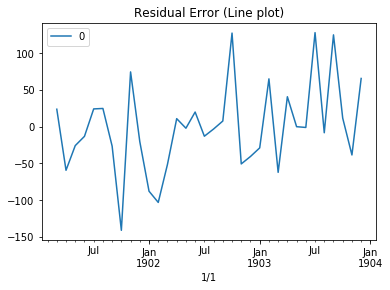

In [66]:
from pandas import DataFrame

# line plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.title('Residual Error (Line plot)')

pyplot.show()


We get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.
Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

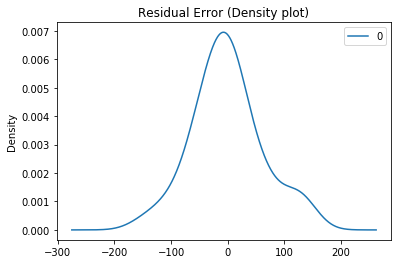

In [67]:
# density plot residual errors

residuals.plot(kind='kde')
pyplot.title('Residual Error (Density plot)')
pyplot.show()


In [68]:
print(residuals.describe())

                0
count   34.000000
mean    -0.864543
std     61.112749
min   -141.014134
25%    -36.113685
50%     -2.684354
75%     24.004705
max    127.834588




The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).



### Forecast ARIMA Model
We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.
We would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’.

We can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.
We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.


In [69]:
X = series.values

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))



C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\richa\Anaconda3\envs\tensorflow\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

predicted=326.860884, expected=339.700000
predicted=391.723475, expected=440.400000
predicted=353.007363, expected=315.900000
predicted=385.696635, expected=439.300000
predicted=367.847630, expected=401.300000
predicted=448.605014, expected=437.400000
predicted=401.917980, expected=575.500000
predicted=429.887294, expected=407.600000
predicted=514.777918, expected=682.000000
predicted=442.026633, expected=475.300000
predicted=651.955555, expected=581.300000
predicted=561.306375, expected=646.900000


Now we have prediction and expected value of  each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

In [70]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6670.450


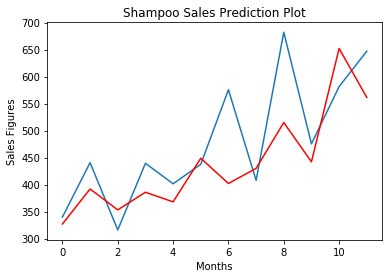

In [71]:
# plot

pyplot.plot(test)
pyplot.plot(predictions, color='red')

pyplot.title('Shampoo Sales Prediction Plot')
pyplot.xlabel('Months')
pyplot.ylabel('Sales Figures')

pyplot.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.